# Reference ET from BARRA data

In [1]:
import numpy as np
import time
import os
import matplotlib as plt
import sys
import glob
import dask
from dask.distributed import Client
import tempfile
import xarray as xr

sys.path.append('/g/data/mn51/users/dh4185/hazards-drought/eddi/')
from pet_eddi import compute_daily_FAO56_PET, compute_EDDI

import warnings
warnings.simplefilter("ignore", FutureWarning)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [2]:
# Dask settings
dask.config.set({
    #'array.chunk-size': "256 MiB",
    #'array.slicing.split_large_chunks': True, 
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #< This should use the new behaviour which helps with memory pile up
})

mem_lim = "252000mb" # 252000mb 63000mb
worker_n = 30
       
client = Client(n_workers=worker_n, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = mem_lim)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 30
Total threads: 30,Total memory: 6.88 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39689,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33939,Total threads: 1
Dashboard: /proxy/42487/status,Memory: 234.69 GiB
Nanny: tcp://127.0.0.1:46023,


2025-12-11 16:51:14,966 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0e25c394671a04c84c582605c3fd7e36 initialized by task ('rechunk-merge-rechunk-transfer-19680585110617231d59480dfd3755f3', 0, 0, 0, 1, 0, 0) executed on worker tcp://127.0.0.1:38985
2025-12-11 16:51:15,974 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0e25c394671a04c84c582605c3fd7e36 deactivated due to stimulus 'task-finished-1765432275.9722078'
2025-12-11 16:51:23,610 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0e25c394671a04c84c582605c3fd7e36 initialized by task ('rechunk-merge-rechunk-transfer-19680585110617231d59480dfd3755f3', 0, 0, 0, 1, 0, 0) executed on worker tcp://127.0.0.1:37881
2025-12-11 16:51:24,450 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0e25c394671a04c84c582605c3fd7e36 deactivated due to stimulus 'task-finished-1765432284.447591'


In [3]:
# client.close()

In [4]:
######################## Modify ##############################
barra_v = "BARRA-R2" #BARRA-R2
startY = 1980
endY = 2025
out_dir = f"/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/{barra_v}/"
lat_slice = slice(-38,-33)#(-45,-10)
lon_slice = slice(140,145)#(115,155)
eddi_cat_switch = True # True: add EDDI categories according to US Drought Monitor

######################## Don't change #####################
grid = "AUS-11" if barra_v == "BARRA-R2" else "AUST-04"
root_dir = f"/g/data/ob53/BARRA2/output/reanalysis/{grid}/BOM/ERA5/historical/hres/{barra_v}/v1/day/"
chunks = {"time":30, "lat":100, "lon":100}

barra_glob_attrs = ["axiom_version","axiom_schemas_version","axiom_schema","productive_version",
              "variable_version","Conventions","activity_id","title","source","project",
              "program","summary","publisher_institution","processing_level","version_realisation",
              "institution_id","source_id","driving_variant_label","driving_experiment_id",
              "driving_institution_id","driving_experiment","driving_source_id","nesting_source_id",
              "project_id","domain","domain_id","standard_name_vocabulary","tracking"]

def preprocess_domain(ds,lat_slice,lon_slice):
    if lat_slice is None and lon_slice is None:
        return ds
    else:
        return ds.sel(lat=lat_slice,lon=lon_slice)

# Netcdf encoding to save space
enc_et0 = {"ET0": {
        "zlib": True,
        "complevel": 1,
        "shuffle": True
        }
      }

enc_eddi1 = {"EDDI": {
        "zlib": True,
        "complevel": 1,
        "shuffle": True
        }
      }

enc_eddi2 = {"EDDI": {
        "zlib": True,
        "complevel": 1,
        "shuffle": True
        },
             "EDDI_cat": {
        "zlib": True,
        "complevel": 1,
        "shuffle": True
        }
      }

enc_eddi = enc_eddi2 if eddi_cat_switch == True else enc_eddi1

# Reference ET (ETo)

In [5]:
%%time

#< Read orography file
orog_file = f"/g/data/ob53/BARRA2/output/reanalysis/{grid}/BOM/ERA5/historical/hres/{barra_v}/v1/fx/orog/latest/orog_{grid}_ERA5_historical_hres_BOM_{barra_v}_v1.nc"
elev = xr.open_dataset(orog_file).sel(lat=lat_slice,lon=lon_slice)['orog']

for year in range(startY,endY+1):
    print(year)
    print(f"==================== Processing {year-startY+1}/{len(range(startY,endY+1))} ====================")
    # Start the lap timer
    start_time = time.time()
    
    et_filename = f"{out_dir}ET0_FAO56_{grid}_ERA5_historical_hres_BOM_{barra_v}_v1_day_{year}01-{year}12.nc"
    print(et_filename)

    if os.path.exists(et_filename):
        print("file exists.")
    
    else:
    
        # Get files
        print("Read tasmax...")
        tasmax_files = glob.glob(f"{root_dir}tasmax/latest/tasmax_{grid}_ERA5_historical_hres_BOM_{barra_v}_v1_day_{year}*.nc")
        ds_tasmax = xr.open_mfdataset(tasmax_files,
                                   parallel=True,
                                   preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)
        tasmax = ds_tasmax['tasmax']
        # Convert temperature from K to degC
        tasmax = tasmax - 273.15
        tasmax.attrs["units"] = "C"

        print("Read tasmin...")
        tasmin_files = glob.glob(f"{root_dir}tasmin/latest/tasmin_{grid}_ERA5_historical_hres_BOM_{barra_v}_v1_day_{year}*.nc")
        tasmin = xr.open_mfdataset(tasmin_files,
                                   parallel=True,
                                   preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['tasmin']
        # Convert temperature from K to degC
        tasmin = tasmin - 273.15
        tasmin.attrs["units"] = "C"

        print("Read rsds...")
        rsds_files = glob.glob(f"{root_dir}rsds/latest/rsds_{grid}_ERA5_historical_hres_BOM_{barra_v}_v1_day_{year}*.nc")
        rsds = xr.open_mfdataset(rsds_files,
                                 parallel=True,
                                 preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['rsds']

        print("Read hurs...")
        hurs_files = glob.glob(f"{root_dir}hurs/latest/hurs_{grid}_ERA5_historical_hres_BOM_{barra_v}_v1_day_{year}*.nc")
        hurs = xr.open_mfdataset(hurs_files,
                                 parallel=True,
                                 preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['hurs']

        print("Read psl...")
        psl_files = glob.glob(f"{root_dir}psl/latest/psl_{grid}_ERA5_historical_hres_BOM_{barra_v}_v1_day_{year}*.nc")
        psl = xr.open_mfdataset(psl_files,
                                parallel=True,
                                preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['psl']

        print("Read sfcWind...")
        sfcWind_files = glob.glob(f"{root_dir}sfcWind/latest/sfcWind_{grid}_ERA5_historical_hres_BOM_{barra_v}_v1_day_{year}*.nc")
        sfcWind = xr.open_mfdataset(sfcWind_files,
                                    parallel=True,
                                    preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['sfcWind']
    
        glob_attrs = {k: ds_tasmax.attrs[k] for k in barra_glob_attrs if k in ds_tasmax.attrs}

        
        print("Start calculation...")
        # Wrap the function call in delayed
        ET0= compute_daily_FAO56_PET(
            tasmax=tasmax,
            tasmin=tasmin,
            rsds=rsds,
            hurs=hurs,
            sfcWind=sfcWind,
            psl=psl,
            elev=elev,
            crop="short",
            freq="day",
            global_attrs=glob_attrs
        )
        
        # --- This triggers the actual computation in parallel ---
        ET0 = ET0.compute()

        ET0.to_netcdf(et_filename, encoding=enc_et0)
        
        # End the timer
        print(f"Done. Time taken: {(time.time()- start_time):.2f} seconds")

1980
==================== Processing 1/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198001-198012.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----
Done. Time taken: 107.09 seconds
1981
==================== Processing 2/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198101-198112.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----
Done. Time taken: 54.88 seconds
1982
==================== Processing 3/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_B

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 10.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Done. Time taken: 44.75 seconds
1983
==================== Processing 4/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198301-198312.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----
Done. Time taken: 39.08 seconds
1984
==================== Processing 5/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198401-198412.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 9.79 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Done. Time taken: 41.18 seconds
1985
==================== Processing 6/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198501-198512.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----
Done. Time taken: 37.34 seconds
1986
==================== Processing 7/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198601-198612.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 9.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Done. Time taken: 44.18 seconds
1987
==================== Processing 8/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198701-198712.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 9.76 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Done. Time taken: 45.95 seconds
1988
==================== Processing 9/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198801-198812.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----
Done. Time taken: 34.81 seconds
1989
==================== Processing 10/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198901-198912.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----
Done. Time taken: 37.66 seconds
1990
==================== Processing 11/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FA

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 9.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Done. Time taken: 50.58 seconds
1991
==================== Processing 12/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_199101-199112.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 15.20 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Done. Time taken: 78.81 seconds
1992
==================== Processing 13/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_199201-199212.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----
Done. Time taken: 6.65 seconds
1993
==================== Processing 14/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_199301-199312.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----
Done. Time taken: 7.72 seconds
1994
==================== Processing 15/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.68 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Done. Time taken: 68.46 seconds
2008
==================== Processing 29/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_200801-200812.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----
Done. Time taken: 7.94 seconds
2009
==================== Processing 30/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_200901-200912.nc
Read tasmax...
Read tasmin...
Read rsds...
Read hurs...
Read psl...
Read sfcWind...
Start calculation...
----- Start calculation ... -----
Done. Time taken: 8.29 seconds
2010
==================== Processing 31/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO

# EDDI calculation

In [5]:
%%time
# Read ETo data
indir = f"/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/{barra_v}/"
outdir = f"/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/{barra_v}/"
files = sorted(glob.glob(f"{indir}ET0_FAO56_{grid}_ERA5_historical_hres_BOM_{barra_v}_v1_day_*.nc"))

ds_ET0 = xr.open_mfdataset(files, parallel=True)
ds_ET0 = ds_ET0.chunk({"time":-1,"lat":20,"lon":20})
ds_ET0

CPU times: user 6.06 s, sys: 3.47 s, total: 9.53 s
Wall time: 17.2 s


<xarray.Dataset> Size: 138MB
Dimensions:  (time: 16680, lat: 46, lon: 45)
Coordinates:
  * time     (time) datetime64[ns] 133kB 1980-01-01T12:00:00 ... 2025-08-31T1...
  * lat      (lat) float64 368B -37.95 -37.84 -37.73 ... -33.22 -33.11 -33.0
  * lon      (lon) float64 360B 140.1 140.2 140.3 140.4 ... 144.7 144.8 144.9
Data variables:
    ET0      (time, lat, lon) float32 138MB dask.array<chunksize=(16680, 20, 20), meta=np.ndarray>
Attributes: (12/28)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1D.json
    productive_version:        edfab29
    variable_version:          v20231001
    Conventions:               CF-1.10, ACDD-1.3
    ...                        ...
    project_id:                BARRA2
    domain:                    Australasia
    domain_id:                 AUS-11
    standard_name_vocabulary:  CF Standard Name Table v79
    description:               FAO-56 crop reference evapotranspiration (ETo)...
    history:                   Thu Dec 11 16:28:15 2025: /g/data/xp65/public/...

In [6]:
%%time
glob_attrs = {k: ds_ET0.attrs[k] for k in barra_glob_attrs if k in ds_ET0.attrs}
_ndays=30

compute_EDDI(
    ds_ET0.ET0,
    ndays=_ndays,
    compute_categories=eddi_cat_switch,
    outdir=outdir,
    filename = f"EDDI_{_ndays}day_{grid}_ERA5_historical_hres_BOM_{barra_v}_v1_day",
    enc = enc_eddi,
    global_attrs = glob_attrs
    )


Writing 1980...
Writing 1981...
Writing 1982...
Writing 1983...
Writing 1984...
Writing 1985...
Writing 1986...
Writing 1987...
Writing 1988...
Writing 1989...
Writing 1990...
Writing 1991...
Writing 1992...
Writing 1993...
Writing 1994...
Writing 1995...
Writing 1996...
Writing 1997...
Writing 1998...
Writing 1999...
Writing 2000...
Writing 2001...
Writing 2002...
Writing 2003...
Writing 2004...
Writing 2005...
Writing 2006...
Writing 2007...
Writing 2008...
Writing 2009...
Writing 2010...
Writing 2011...
Writing 2012...
Writing 2013...
Writing 2014...
Writing 2015...
Writing 2016...
Writing 2017...
Writing 2018...
Writing 2019...
Writing 2020...
Writing 2021...
Writing 2022...
Writing 2023...
Writing 2024...
Writing 2025...
Done.
CPU times: user 1min 7s, sys: 24.7 s, total: 1min 32s
Wall time: 2min 10s


<xarray.Dataset> Size: 4MB
Dimensions:   (time: 243, lat: 46, lon: 45)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2025-01-01T12:00:00 ... 2025-08-31T12...
  * lat       (lat) float64 368B -37.95 -37.84 -37.73 ... -33.22 -33.11 -33.0
  * lon       (lon) float64 360B 140.1 140.2 140.3 140.4 ... 144.7 144.8 144.9
Data variables:
    EDDI      (time, lat, lon) float32 2MB dask.array<chunksize=(29, 46, 45), meta=np.ndarray>
    EDDI_cat  (time, lat, lon) float32 2MB dask.array<chunksize=(29, 46, 45), meta=np.ndarray>
Attributes: (12/28)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1D.json
    productive_version:        edfab29
    variable_version:          v20231001
    Conventions:               CF-1.10, ACDD-1.3
    ...                        ...
    project_id:                BARRA2
    domain:                    Australasia
    domain_id:                 AUS-11
    standard_name_vocabulary:  CF Standard Name Table v79
    description:               Evaporative demand drought index (EDDI, Hobbin...
    history:                   Thu Dec 11 16:53:23 2025: /g/data/xp65/public/...

In [7]:
# Read EDDI data
eddi = xr.open_mfdataset(glob.glob(f"{outdir}EDDI_30day_{grid}_ERA5_historical_hres_BOM_{barra_v}_v1_day_*.nc"))#.sel(lat=lat_slice,lon=lon_slice)
eddi

<xarray.Dataset> Size: 276MB
Dimensions:   (time: 16639, lat: 46, lon: 45)
Coordinates:
  * time      (time) datetime64[ns] 133kB 1980-01-30T12:00:00 ... 2025-08-31T...
  * lat       (lat) float64 368B -37.95 -37.84 -37.73 ... -33.22 -33.11 -33.0
  * lon       (lon) float64 360B 140.1 140.2 140.3 140.4 ... 144.7 144.8 144.9
Data variables:
    EDDI      (time, lat, lon) float32 138MB dask.array<chunksize=(336, 46, 45), meta=np.ndarray>
    EDDI_cat  (time, lat, lon) float32 138MB dask.array<chunksize=(336, 46, 45), meta=np.ndarray>
Attributes: (12/28)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1D.json
    productive_version:        edfab29
    variable_version:          v20231001
    Conventions:               CF-1.10, ACDD-1.3
    ...                        ...
    project_id:                BARRA2
    domain:                    Australasia
    domain_id:                 AUS-11
    standard_name_vocabulary:  CF Standard Name Table v79
    description:               Evaporative demand drought index (EDDI, Hobbin...
    history:                   Thu Dec 11 16:51:20 2025: /g/data/xp65/public/...

## Example output

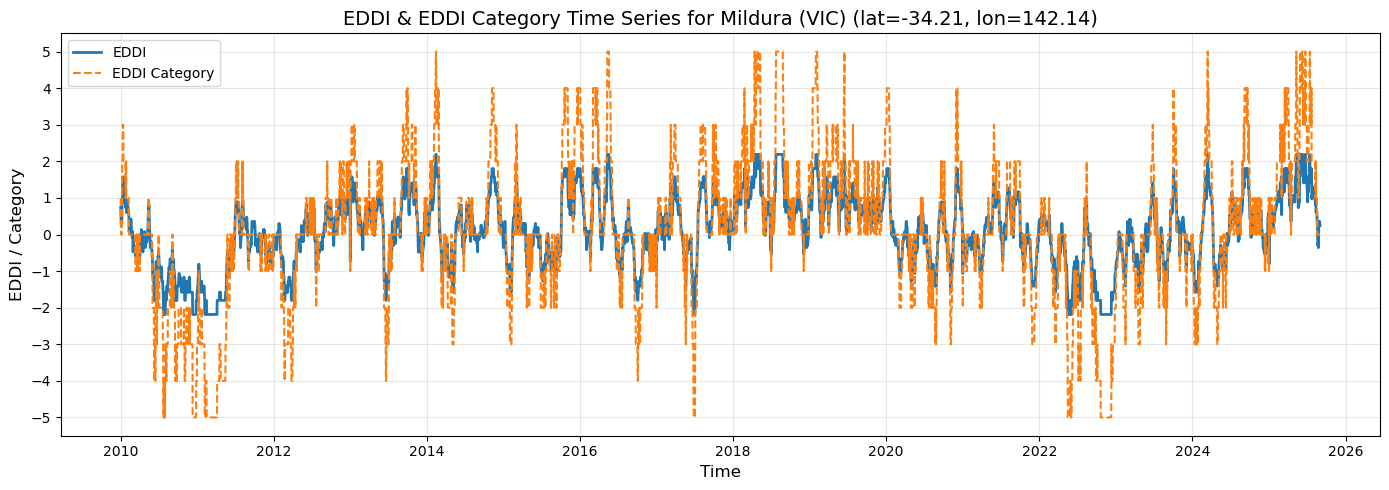

In [8]:
import matplotlib.pyplot as plt

# Extract the time series
ts_eddi = eddi.EDDI.sel(lat=-34.21, lon=142.14, method="nearest").sel(time=slice("2010", "2025"))
ts_cat = eddi.EDDI_cat.sel(lat=-34.21, lon=142.14, method="nearest").sel(time=slice("2010", "2025"))

# Create figure
plt.figure(figsize=(14, 5))

# Plot both
plt.plot(ts_eddi.time, ts_eddi, label="EDDI", linewidth=2)
plt.plot(ts_cat.time, ts_cat, label="EDDI Category", linestyle="--", linewidth=1.5)

# Formatting
plt.title("EDDI & EDDI Category Time Series for Mildura (VIC) (lat=-34.21, lon=142.14)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("EDDI / Category", fontsize=12)
plt.yticks(np.arange(-5,6,1))
plt.grid(True, alpha=0.3)
plt.legend()

# Optional: tight layout for cleaner spacing
plt.tight_layout()

plt.show()
